In [126]:
import requests

# Adres URL pliku na Physionet
# https://physionet.org/content/eegmmidb/1.0.0/
url = 'https://physionet.org/files/eegmmidb/1.0.0/S001/S001R01.edf'

# Pobierz plik
response = requests.get(url)

# Sprawdź, czy pobieranie zakończyło się sukcesem
if response.status_code == 200:
    # Zapisz zawartość pliku do lokalnego pliku
    with open('S001R01.edf', 'wb') as f:
        f.write(response.content)
    print('Plik został pobrany pomyślnie.')
else:
    print('Wystąpił błąd podczas pobierania pliku:', response.status_code)

Plik został pobrany pomyślnie.


In [127]:
import mne
import numpy as np
import matplotlib.pyplot as plt



# Wczytaj plik .edf
filename = 'S001R01.edf'
raw = mne.io.read_raw_edf(filename)
raw.load_data()

# Wybierz kanał EEG do aproksymacji
channel_idx = 0  # Indeks kanału EEG

# Pobierz dane EEG i informacje o próbkowaniu
eeg_signals = raw._data[channel_idx]
fs = raw.info['sfreq']
duration = raw.n_times / fs

# Parametry sztucznego szumu
amplitude = 0.0001  # Amplituda szumu

# Wygeneruj szum biały
num_samples = len(eeg_signals)
white_noise = np.random.normal(0, amplitude, num_samples)

# Dodaj szum biały do sygnału EEG
eeg_signals_with_noise = eeg_signals + white_noise




Extracting EDF parameters from d:\Programowanie\Python\Magisterka\Obliczeniowe podstawy\EEG_signal_denoise\S001R01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 9759  =      0.000 ...    60.994 secs...


<h1>Aproksymacja<h1>

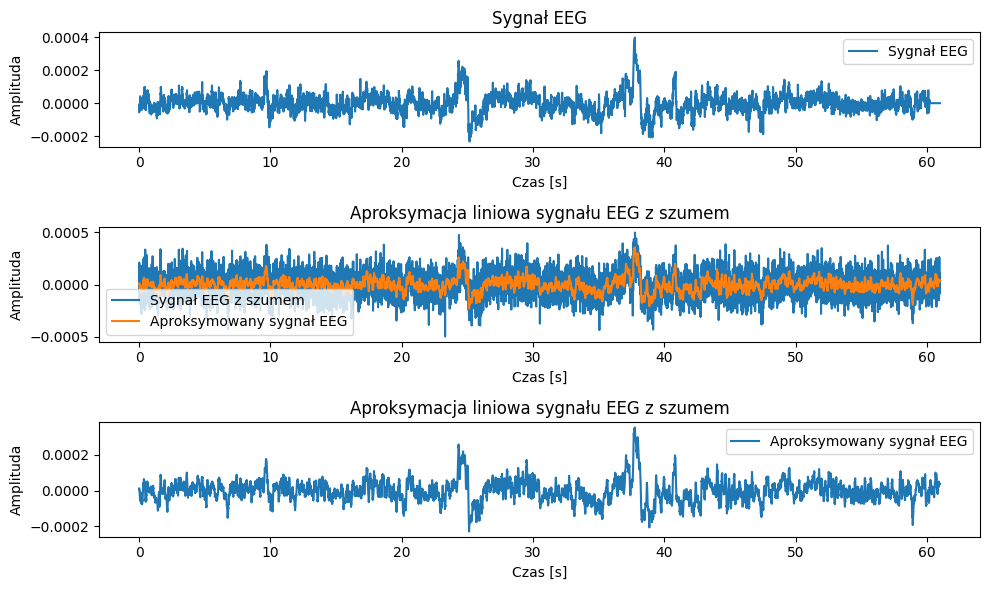

In [128]:
from scipy.signal import savgol_filter

window_length = 25 # Długość okna (musi być nieparzysta)
poly_order = 3 # Rząd wielomianu

# Metoda Savitzky-Golay do aproksymacji sygnału EEG
y_approx = savgol_filter(eeg_signals_with_noise, window_length, poly_order)


# Wykresy
plt.figure(figsize=(10, 6))
plt.subplot(3, 1, 1)
plt.plot(np.linspace(0, duration, num_samples), eeg_signals, label='Sygnał EEG')
plt.xlabel('Czas [s]')
plt.ylabel('Amplituda')
plt.title('Sygnał EEG')
plt.legend()

plt.subplot(3, 1, 2)
plt.plot(np.linspace(0, duration, num_samples), eeg_signals_with_noise, label='Sygnał EEG z szumem')
plt.plot(np.linspace(0, duration, num_samples), y_approx, label='Aproksymowany sygnał EEG')
plt.xlabel('Czas [s]')
plt.ylabel('Amplituda')
plt.title('Aproksymacja liniowa sygnału EEG z szumem')
plt.legend()


plt.subplot(3, 1, 3)
plt.plot(np.linspace(0, duration, num_samples), y_approx, label='Aproksymowany sygnał EEG')
plt.xlabel('Czas [s]')
plt.ylabel('Amplituda')
plt.title('Aproksymacja liniowa sygnału EEG z szumem')
plt.legend()

plt.tight_layout()
plt.show()

<h1>Model Autoregresyjny<h1>

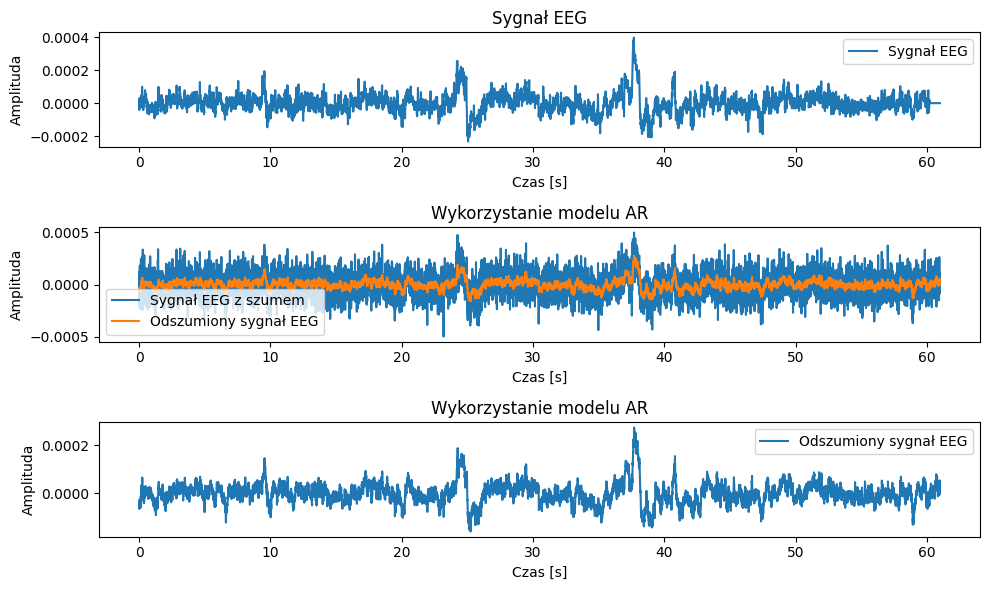

<function print(*args, sep=' ', end='\n', file=None, flush=False)>

In [129]:
import statsmodels.api as sm
from statsmodels.tsa.ar_model import AutoReg

# Usuń średnią z sygnału EEG z szumem
eeg_signals_with_noise_mean = np.mean(eeg_signals_with_noise)
eeg_signals_with_noise_centered = eeg_signals_with_noise - eeg_signals_with_noise_mean

# Utwórz model AR
order = 30
model = AutoReg(eeg_signals_with_noise_centered, lags = order)
ar_results = model.fit()

# Użyj modelu AR do odszumienia sygnału EEG
eeg_signals_denoised = ar_results.predict(start=order, end=num_samples-1)
eeg_signals_denoised += eeg_signals_with_noise_mean



plt.figure(figsize=(10, 6))
plt.subplot(3, 1, 1)
plt.plot(np.linspace(0, duration, num_samples-30), eeg_signals[30:], label='Sygnał EEG')
plt.xlabel('Czas [s]')
plt.ylabel('Amplituda')
plt.title('Sygnał EEG')
plt.legend()


plt.subplot(3, 1, 2)
plt.plot(np.linspace(0, duration, num_samples-30), eeg_signals_with_noise[30:], label='Sygnał EEG z szumem')
plt.plot(np.linspace(0, duration, eeg_signals_denoised.shape[0]), eeg_signals_denoised, label='Odszumiony sygnał EEG')
plt.xlabel('Czas [s]')
plt.ylabel('Amplituda')
plt.title('Wykorzystanie modelu AR')
plt.legend()



plt.subplot(3, 1, 3)
plt.plot(np.linspace(0, duration, eeg_signals_denoised.shape[0]), eeg_signals_denoised, label='Odszumiony sygnał EEG')
plt.xlabel('Czas [s]')
plt.ylabel('Amplituda')
plt.title('Wykorzystanie modelu AR')
plt.legend()

plt.tight_layout()
plt.show()


print 



<h1>Transformata falkowa<h1>

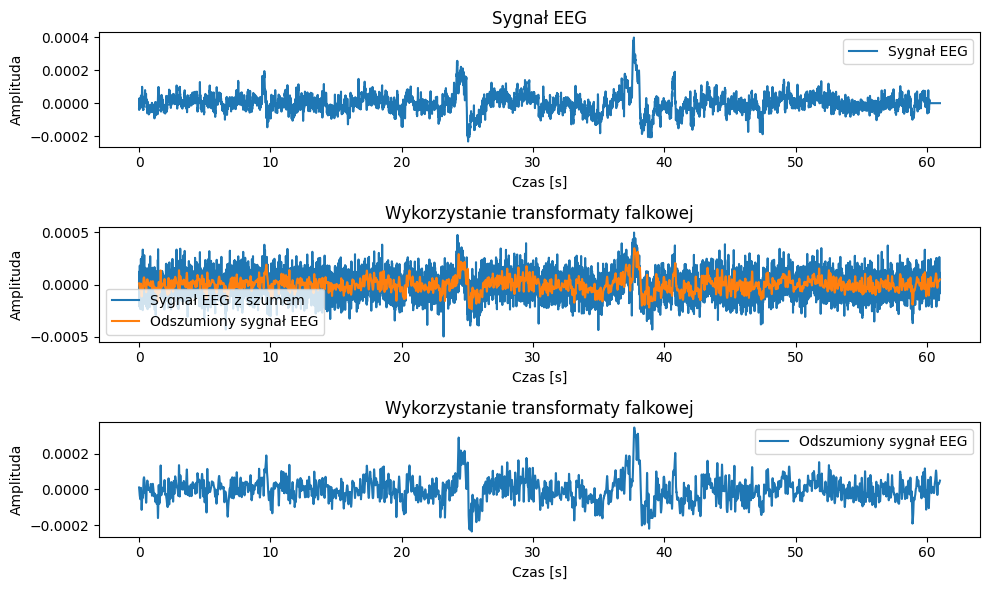

In [131]:
import pywt

# Usunięcie średniej z sygnału EEG z szumem
eeg_signals_with_noise_mean = np.mean(eeg_signals_with_noise)
eeg_signals_with_noise_centered = eeg_signals_with_noise - eeg_signals_with_noise_mean

# Wybór typu falki i poziomu dekompozycji
wavelet = 'db4'
level = 3

# Zastosowanie falkowej dekompozycji do sygnału EEG z szumem
coeffs = pywt.wavedec(eeg_signals_with_noise_centered, wavelet, level=level)

# Ustawienie wartości progu dla usuwania szumów
threshold = 2.0 * np.sqrt(2.0 * np.log(len(eeg_signals_with_noise_centered)))

# Zastosowanie progowania do współczynników falkowych
new_coeffs = []
for i, coeff in enumerate(coeffs):
    if i == 0:
        new_coeffs.append(coeff)
        continue
    new_coeff = pywt.threshold(coeff, threshold, 'soft')
    new_coeffs.append(new_coeff)

# Rekonstrukcja sygnału EEG po usunięciu szumów
eeg_signals_denoised_1 = pywt.waverec(new_coeffs, wavelet)

# Dodanie z powrotem średniej
eeg_signals_denoised_1 = eeg_signals_denoised_1 + eeg_signals_with_noise_mean





plt.figure(figsize=(10, 6))
plt.subplot(3, 1, 1)
plt.plot(np.linspace(0, duration, num_samples-30), eeg_signals[30:], label='Sygnał EEG')
plt.xlabel('Czas [s]')
plt.ylabel('Amplituda')
plt.title('Sygnał EEG')
plt.legend()


plt.subplot(3, 1, 2)
plt.plot(np.linspace(0, duration, num_samples-30), eeg_signals_with_noise[30:], label='Sygnał EEG z szumem')
plt.plot(np.linspace(0, duration, eeg_signals_denoised_1.shape[0]), eeg_signals_denoised_1, label='Odszumiony sygnał EEG')
plt.xlabel('Czas [s]')
plt.ylabel('Amplituda')
plt.title('Wykorzystanie transformaty falkowej')
plt.legend()



plt.subplot(3, 1, 3)
plt.plot(np.linspace(0, duration, eeg_signals_denoised_1.shape[0]), eeg_signals_denoised_1, label='Odszumiony sygnał EEG')
plt.xlabel('Czas [s]')
plt.ylabel('Amplituda')
plt.title('Wykorzystanie transformaty falkowej')
plt.legend()

plt.tight_layout()
plt.show()

